In [2]:
import numpy as np 
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys 
import matplotlib.pyplot as plt 
import matplotlib_inline 
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
nImages = 3000
imgSize = 64
x = np.linspace(-4,4,imgSize)
X, Y = np.meshgrid(x, x)

# initialize tensors containing images and labels 
images = torch.zeros(nImages, 1, imgSize, imgSize)
for i in range(nImages):
    
    # create the gaussiam with randon centers 
    ro = 2*np.random.randn(2) # random offset 
    width = np.random.randn()/.6 + 1.8
    G = np.exp(-((X - ro[0])**2 + (Y - ro[1])**2)/ (2*width**2))
    
    G = G + np.random.randn(imgSize, imgSize)/15
    
    # add to the tensor
    images[i, :,:,:] = torch.Tensor(G).view(1, imgSize, imgSize)
    

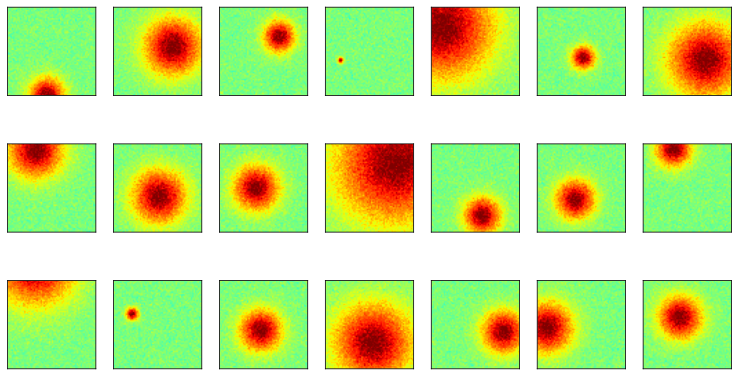

In [5]:
fig, axs = plt.subplots(3, 7, figsize = (13,7))

for i, ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(nImages)
    G = np.squeeze(images[whichpic, :,:])
    ax.imshow(G, vmin = -1, vmax = 1, cmap = 'jet')
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()

In [6]:
class discriminatorNet(nn.Module):
    
    def __init__(self):
        super(discriminatorNet, self).__init__()
        
        # convolutional layers (initial size = 64x64)
        self.conv1 = nn.Conv2d(1, 64, 4, 2, 1, bias = False)  # size: 32x32
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1, bias = False) # size: 16x16
        self.conv3 = nn.Conv2d(128, 1, 16, 2, 0, bias = False) # size: 8x8
        
        # batch norm 
        self.bn2 = nn.BatchNorm2d(128)
        
        
    
    def forward(self, x):
        
        x = F.leaky_relu(self.conv1(x), .2)
        x = F.leaky_relu(self.conv2(x), .2)
        x = self.bn2(x)
        x = torch.sigmoid(self.conv3(x)).view(-1, 1)
        
        return x
        
dnet = discriminatorNet()
y = dnet(torch.randn(10, 1, 64, 64))
y.shape
        

torch.Size([10, 1])

torch.Size([10, 1, 64, 64])


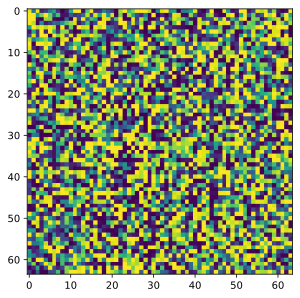

In [17]:
class generatorNet(nn.Module):
    
    def __init__(self):
        super(generatorNet, self).__init__()
        
        self.conv1 = nn.ConvTranspose2d(100, 256, 4, 4, 0, bias = False) # 4x4
        self.conv2 = nn.ConvTranspose2d(256, 128, 4, 4, 0, bias = False) # 16x16
        self.conv3 = nn.ConvTranspose2d(128, 1, 4, 4, 0, bias = False)    # 64x64
        
        # batch norm 
        self.bn1 = nn.BatchNorm2d(256)
        self.bn2 = nn.BatchNorm2d(128)
        
        
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = torch.tanh(self.conv3(x))
        
        return x
        
    
        
gnet = generatorNet() 
y = gnet(torch.randn(10, 100, 1, 1))
print(y.shape)
plt.imshow(y[0, :, :].squeeze().detach().numpy())

In [18]:
lossfun = nn.BCELoss()

dnet = discriminatorNet().to(device)
gnet = generatorNet().to(device)

d_optimizer = torch.optim.Adam(dnet.parameters(), lr = .0002, betas = (.5, .999))
g_optimizer = torch.optim.Adam(gnet.parameters(), lr = .0002, betas = (.5, .999))


In [19]:
# training parameters 
numepochs = 1000
batchsize = 86
losses = []
disDecs = []

for epochi in range(numepochs):
    
    ridx = torch.randint(images.shape[0], (batchsize, ))
    data = images[ridx, :].to(device)
    
    # create labels for real and fake images 
    real_labels = torch.ones(batchsize, 1).to(device)
    fake_labels = torch.zeros(batchsize, 1).to(device)
    
    ### Train the  Discriminator
    pred_real = dnet(data)
    d_loss_real = lossfun(pred_real, real_labels)
    
    # forward pass and loss for fake 
    fake_data = torch.randn(batchsize, 100, 1, 1).to(device)
    fake_images = gnet(fake_data)
    pred_fake = dnet(fake_images)
    d_loss_fake = lossfun(pred_fake, fake_labels)
    
    # collect loss 
    d_loss = d_loss_real + d_loss_fake 
    
    # back prop 
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()
    
    
    ### Train the generator 
    fake_images = gnet(torch.randn(batchsize, 100, 1, 1).to(device))
    pred_fake = dnet(fake_images)
    
    # compute loss 
    g_loss = lossfun(pred_fake, real_labels)
    
    # back prop 
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()
    
    pred_real = pred_real.cpu()
    pred_fake = pred_fake.cpu()
    losses.append([d_loss.item(), g_loss.item()])
    d1 = torch.mean((pred_real > .5).float()).detach()
    d2 = torch.mean((pred_fake > .5).float()).detach()
    disDecs.append([d1, d2])
    
    if (epochi+1)%50 == 0:
        msg = f'Finished Epoch {epochi+1}/{numepochs}'
        sys.stdout.write('\r' + msg)
        


Finished Epoch 1000/1000

In [20]:
losses = np.array(losses)
disDecs = np.array(disDecs)

In [21]:
def smooth(x, k = 15):
    return np.convolve(x,np.ones(k)/k,mode = 'same')

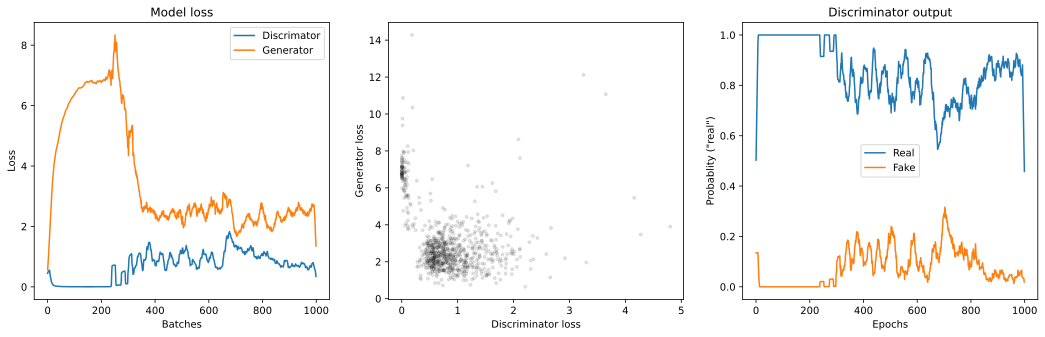

In [22]:
fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].plot(smooth(losses[:,0]))
ax[0].plot(smooth(losses[:,1]))
ax[0].set_xlabel('Batches')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])
# ax[0].set_xlim([500,900])
# ax[0].set_ylim([0,2.5])

ax[1].plot(losses[200:,0],losses[200:,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(smooth(disDecs[:,0]))
ax[2].plot(smooth(disDecs[:,1]))
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real','Fake'])

plt.show()

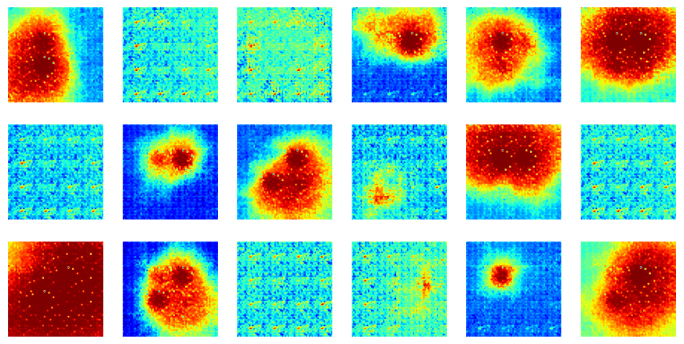

In [23]:
# generate the images from the generator network
gnet.eval()
fake_data = gnet( torch.randn(batchsize,100,1,1).to(device) ).cpu()

# and visualize...
fig,axs = plt.subplots(3,6,figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
  ax.imshow(fake_data[i,].detach().squeeze(),cmap='jet')
  ax.axis('off')

plt.show()